In [1]:
# Cell 0 — install required packages
!pip install -q scikit-learn imbalanced-learn matplotlib seaborn joblib

In [2]:
# Cell 1 — upload CSV (interactive)
from google.colab import files
uploaded = files.upload()  # choose your Autism CSV (e.g. Autism-Child-Data.csv or Autism-Adult-Data.csv)
for fn in uploaded.keys():
    print("Uploaded:", fn)


Saving autism_screening.csv to autism_screening (1).csv
Uploaded: autism_screening (1).csv


In [3]:
# Cell 2 — load CSV and inspect
import glob, pandas as pd, numpy as np
csvs = glob.glob("/content/*.csv")
if not csvs:
    raise FileNotFoundError("No CSV found. Upload the dataset in the previous cell.")
DATAFILE = csvs[0]
print("Loading:", DATAFILE)
df = pd.read_csv(DATAFILE)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Loading: /content/autism_screening.csv
Shape: (704, 21)
Columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2.0,18 and more,?,NO


In [4]:
# Cell 3 — preprocess & detect feature columns
df = df.copy()

# 1) Detect target column candidates
possible_targets = [c for c in df.columns if c.lower() in ('class','class/asd','class_asd','target','asd','result')]
print("Possible target columns found:", possible_targets)

# Choose target column (edit here if auto-detection is wrong)
if 'Class/ASD' in df.columns:
    TARGET_COL = 'Class/ASD'
elif possible_targets:
    TARGET_COL = possible_targets[0]
else:
    TARGET_COL = df.columns[-1]  # fallback: last column

print("Using target column:", TARGET_COL)

# 2) Heuristically find 10 question columns (A1..A10, Q1..Q10, etc.)
question_candidates = [c for c in df.columns if any(tok in c.lower() for tok in ['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','q1','q2','q3','q4','q5','q6','q7','q8','q9','q10','a1_score','a2_score'])]
question_candidates = list(dict.fromkeys(question_candidates))  # unique
print("Detected question-like columns:", question_candidates)

# If fewer than 10, try binary columns detection
if len(question_candidates) < 10:
    bin_cols = [c for c in df.columns if df[c].dropna().astype(str).isin(['0','1','yes','no','Yes','No','YES','NO']).all() and c != TARGET_COL]
    print("Binary-like columns candidates:", bin_cols)
    # pick first 10 excluding target
    question_candidates = [c for c in bin_cols][:10]

# Final QUESTIONS: ensure exactly 10 (if detection failed, edit manually here)
QUESTION_COLS = question_candidates[:10]
if len(QUESTION_COLS) < 10:
    raise ValueError(f"Detected only {len(QUESTION_COLS)} question columns. Please edit Cell 3 and set QUESTION_COLS explicitly.")

print("Final QUESTION_COLS (10):", QUESTION_COLS)

# 3) Detect extra columns (Age, Gender, Jaundice, Family)
extra_cols = []
age_col = next((c for c in ['Age','age','Age_Mons','age_mons','Age_Months','age_months'] if c in df.columns), None)
gender_col = next((c for c in ['Gender','gender','sex'] if c in df.columns), None)
jaundice_col = next((c for c in ['Jaundice','jaundice'] if c in df.columns), None)
family_col = next((c for c in ['Family_mem_with_ASD','family','family_mem_with_asd','family_member_with_asd'] if c in df.columns), None)

if age_col: extra_cols.append(age_col)
if gender_col: extra_cols.append(gender_col)
if jaundice_col: extra_cols.append(jaundice_col)
if family_col: extra_cols.append(family_col)

print("Detected extra columns:", extra_cols)

# 4) Map yes/no strings to 0/1 globally
df = df.replace({'yes':1, 'no':0, 'Yes':1, 'No':0, 'YES':1, 'NO':0})

# 5) Ensure question columns are numeric 0/1
for c in QUESTION_COLS:
    try:
        df[c] = df[c].astype(int)
    except Exception:
        df[c] = df[c].astype(str).str.strip().str.lower().map({'yes':1,'no':0,'y':1,'n':0,'1':1,'0':0}).fillna(0).astype(int)

# 6) Map gender to numeric if present
if gender_col:
    df[gender_col] = df[gender_col].astype(str).str.lower().map({'m':0,'male':0,'f':1,'female':1}).fillna(0).astype(int)

# 7) Prepare ordered feature_cols for training: questions first, then extras in canonical order
feature_cols = QUESTION_COLS.copy()
if age_col and age_col not in feature_cols: feature_cols.append(age_col)
if gender_col and gender_col not in feature_cols: feature_cols.append(gender_col)
if jaundice_col and jaundice_col not in feature_cols: feature_cols.append(jaundice_col)
if family_col and family_col not in feature_cols: feature_cols.append(family_col)

# Fill missing feature columns with zeros (safe)
for c in feature_cols:
    if c not in df.columns:
        df[c] = 0

X = df[feature_cols].fillna(0).astype(float)
y_raw = df[TARGET_COL]

# map common target strings to 0/1
y_mapped = y_raw.astype(str).str.strip().str.lower().map({'yes':1,'no':0,'autism':1,'true':1,'false':0}).fillna(y_raw)
try:
    y = y_mapped.astype(int)
except:
    y = y_raw.astype(int)

print("Final feature columns order:", feature_cols)
print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Possible target columns found: ['result', 'Class/ASD']
Using target column: Class/ASD
Detected question-like columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Final QUESTION_COLS (10): ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Detected extra columns: ['age', 'gender']
Final feature columns order: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender']
X shape: (704, 12)
Target distribution:
 Class/ASD
0    515
1    189
Name: count, dtype: int64


/tmp/ipython-input-2769932153.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'yes':1, 'no':0, 'Yes':1, 'No':0, 'YES':1, 'NO':0})


In [5]:
# Cell 4 — train with SMOTE, gridsearch RandomForest, calibrate probabilities
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train class distribution before SMOTE:", y_train.value_counts())

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE on training
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)
print("Train class distribution after SMOTE:", pd.Series(y_res).value_counts())

# Grid search RandomForest (small grid to be faster; increase if you want)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 8],
    'min_samples_split': [2, 4]
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_res, y_res)

print("Best RF params:", grid.best_params_)
best_rf = grid.best_estimator_

# Calibrate probabilities (isotonic is more flexible; if small data, try 'sigmoid')
calibrated = CalibratedClassifierCV(best_rf, method='isotonic', cv=4)
calibrated.fit(X_res, y_res)

# Evaluate on test
y_pred = calibrated.predict(X_test_scaled)
y_proba = calibrated.predict_proba(X_test_scaled)[:,1] if hasattr(calibrated, "predict_proba") else None

print("\nTest metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1:", f1_score(y_test, y_pred, zero_division=0))
if y_proba is not None:
    try:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    except Exception as e:
        print("ROC AUC calculation failed:", e)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Train class distribution before SMOTE: Class/ASD
0    412
1    151
Name: count, dtype: int64
Train class distribution after SMOTE: Class/ASD
0    412
1    412
Name: count, dtype: int64
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best RF params: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}

Test metrics:
Accuracy: 0.9432624113475178
Precision: 0.9411764705882353
Recall: 0.8421052631578947
F1: 0.8888888888888888
ROC AUC: 0.9772611139499234

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       103
           1       0.94      0.84      0.89        38

    accuracy                           0.94       141
   macro avg       0.94      0.91      0.93       141
weighted avg       0.94      0.94      0.94       141


Confusion matrix:
[[101   2]
 [  6  32]]


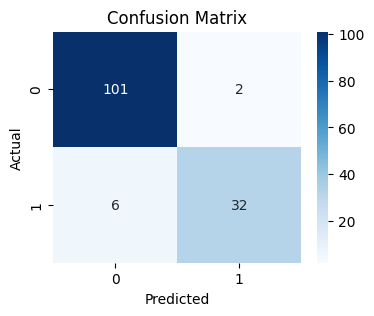

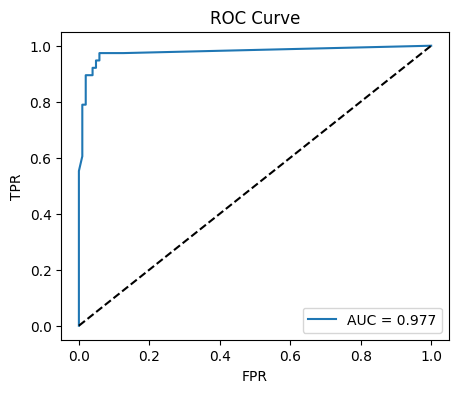

In [6]:
# Cell 5 — plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# ROC if probabilities available
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
    plt.legend()
    plt.show()


In [7]:
# Cell 6 — save artifacts for Streamlit
import joblib, json, os
joblib.dump(calibrated, "/content/asd_model_calibrated.joblib")
joblib.dump(scaler, "/content/scaler.joblib")
metadata = {
    "feature_cols": feature_cols,
    "question_order": QUESTION_COLS,
    "age_col": age_col,
    "gender_col": gender_col,
    "jaundice_col": jaundice_col,
    "family_col": family_col,
    "target_col": TARGET_COL,
    "training_shape": X.shape,
    "best_params": grid.best_params_
}
with open("/content/asd_metadata.json","w") as f:
    json.dump(metadata, f, indent=2)

print("Saved files to /content:")
print(os.listdir("/content"))
print("Saved: asd_model_calibrated.joblib, scaler.joblib, asd_metadata.json")


Saved files to /content:
['.config', 'autism_screening.csv', 'scaler.joblib', 'asd_model_calibrated.joblib', 'asd_metadata.json', '.ipynb_checkpoints', 'sample_data']
Saved: asd_model_calibrated.joblib, scaler.joblib, asd_metadata.json
